Simple Blob Detection recursive algorithm
Created by G.Re

In [14]:
import os
import random
from math import sqrt,floor, pow
from PIL import Image
from functools import reduce
import numpy as np
import matplotlib.patches as ptc
import matplotlib.pyplot as plt
import cv2

In [15]:
image = Image.open('toys.jpg').convert("RGB")
image = image.resize((256,256))

image shape: (256, 256, 3)


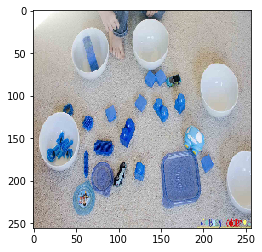

In [16]:
img_array = np.array(image)
image #Image
print('image shape: ' + str(img_array.shape))
plt.imshow(img_array)

colorBlue = (np.array([50,50,160]),np.array([150,150,255])) #color ranges for blue (in RGB)
colorGreen = (np.array([50,150,50]),np.array([150,255,130])) #color ranges for green (in RGB)
colorRed = (np.array([150,60,60]),np.array([255,150,150])) #color ranges for red (in RGB)

In [17]:
class Blob:
    """Blob: a set of pixels that are identified with a specific color/object."""
    def __init__(self,color):
        self.color = color #pair of two 3-dimensional vectors representing
        self.x = 1000
        self.y = 1000
        self.maxX = -1
        self.maxY = -1
        self.height = 0
        self.width = 0
        self.exploredPix = set() #list of already explored pixels.
        self.coloredPix = set()
        #print("This Blob has color ranging from: " + str(self.color))
     
    #Utility function for checking the Color of a pixel
    def checkColor(self,img,x,y):
        channelsEq = np.greater_equal(img[y,x],self.color[0]) & np.less_equal(img[y,x],self.color[1])
        return reduce(lambda x,y: x & y, channelsEq)
    
    #Function for checking if the pixel has already been explored
    def isExplored(self,x,y):
        # for el in self.exploredPix:
        #     if el[0] == x and el[1] == y:
        #         return True
        return (x,y) in self.exploredPix
    
    def colorBlobs(self,img):
        for pix in self.coloredPix:
            img[pix[1],pix[0]] = color[1]
        return img

    #recursive function for the exploration
    def recursiveSearch(self,img,x,y):
        self.exploredPix.add((x,y))
        if(self.checkColor(img,x,y) == False):
            return
        else:
            #check and update elements for the box.
            if x < self.x:
                self.x = x
            if y < self.y:
                self.y = y
            if x > self.maxX:
                self.maxX = x
            if y > self.maxY:
                self.maxY = y

            self.coloredPix.add((x,y))    
            #Up...
            if(self.isExplored(x-1,y)==False and x-1 >= 0):
                self.recursiveSearch(img,x-1,y)
            
            #...then to the left...
            if(self.isExplored(x,y-1) == False and y-1 >= 0):
                self.recursiveSearch(img,x,y-1)
                
            #...then down...
            if(self.isExplored(x+1,y) == False and x+1 < img.shape[1]):
                self.recursiveSearch(img,x+1,y)
            
            #...and finally right!
            if(self.isExplored(x,y+1) == False and y+1 < img.shape[0]):
                self.recursiveSearch(img,x,y+1)
            
            self.width = self.maxX - self.x
            self.height = self.maxY - self.y
            
            return
            
            #finished! 
        
    def clear(self):
        self.color = [] #pair of two 3-dimensional vectors representing
        self.x = 1000
        self.y = 1000
        self.maxX = -1
        self.maxY = -1
        self.height = 0
        self.width = 0
        self.exploredPix = set() #list of already explored pixels.
                     
            
class BlobsFactory:
    """BlobsFactory: simple class for building a Blob. It takes two colors to be recognized within the image
    (the number of chosen colors is precise for our purposes, it can be changed to a list of colors encoded in RGB). """
    def __init__(self,color1,color2):
        self.color1 = color1 #First color to identify
        self.color2 = color2 #Second color to identify
        self.occupiedPix = set()
        self.blobs = []
        
    def checkColor(self,img,x,y,color):
        channelsEq = np.greater_equal(img[y,x],color[0]) & np.less_equal(img[y,x],color[1])
        return reduce(lambda x,y: x & y, channelsEq)
    
    def isExplored(self,x,y):
        # for el in self.occupiedPix:
        #     if el[0] == x and el[1] == y:
        #         return True
        return (x,y) in self.occupiedPix
        
    def search(self,img):   
        for i in range(img.shape[1]):
            for j in range(img.shape[0]):
                if self.checkColor(img,i,j,self.color1) and self.isExplored(i,j) == False:
                    b = Blob(self.color1)
                    # Perform recursive search and create a Blob
                    b.recursiveSearch(img,i,j)
                    
                    #Cover the entire area as explored (this is done in order to do not cover already covered areas)
                    for w in range(b.width+1):
                        for z in range(b.height+1):
                            self.occupiedPix.add((w + b.x, z + b.y))
                
                    #Add the cluster if it is big enough (fixed for now, could be a % of image area)
                    if len(b.exploredPix) > 20:    
                        self.blobs.append(b)
        print("BLOBS ------------------------")                
        for el in self.blobs:
            print(el.x,el.y,el.width,el.height)
        print("------------------------------")
            
    def showFrames(self,img):
        'displays the boxes in the image'
        figure,ax = plt.subplots(1)
        ax.imshow(img)
        for el in self.blobs:
            rect = ptc.Rectangle((el.x,el.y),el.width,el.height,edgecolor='red', facecolor='none',label='blue')
            ax.add_patch(rect)
            ax.scatter(el.width/2 + el.x, el.height/2 + el.y ,marker=(5,2),c = 'r')
            
    def clear(self):
        for el in self.blobs:
            el.clear()
        self.blobs = []
        self.occupiedPix = set()
        
    def selectBest(self):
        maxDim = -1
        b = None
        for el in self.blobs:
            if len(el.exploredPix) > maxDim:
                b = el
        return b
    
    def imageSectors(self, img, scale_factor = 10):
        "Function for creating and analyzing sectors of fixed scale within the image"
        new_img= np.zeros(img.shape, dtype=np.uint8)
        num_sectors = int(img.shape[0]/scale_factor) * int(img.shape[1]/scale_factor)
        # print(str(num_sectors) + " -> " + str(int(img.shape[1]/scale_factor)) +  " " + str(int(img.shape[0]/scale_factor)))
        #Always for our purposes, it could be more general
        important_sectors_blue = []
        important_sectors_red = []
        for s in range(num_sectors):
            rgb = [0,0,0]
            area = 0
            percr = 0
            percb = 0
            sec_x_offset = floor(s / int(img.shape[1]/scale_factor))
            sec_y_offset = s - sec_x_offset*int(img.shape[1]/scale_factor)
            #Compute the ratio of colored pixels for each sector and the average color in the box
            for i in range(scale_factor):
                for j in range(scale_factor):
                    area += 1
                    x = i + sec_x_offset*scale_factor
                    y = j + sec_y_offset*scale_factor
                    rgb[0] += img[i+sec_x_offset*scale_factor, j+sec_y_offset*scale_factor, 0]
                    rgb[1] += img[i+sec_x_offset*scale_factor, j+sec_y_offset*scale_factor, 1]
                    rgb[2] += img[i+sec_x_offset*scale_factor, j+sec_y_offset*scale_factor, 2]
                    if(self.checkColor(img,y,x,self.color1)):
                        percb+=1
                    if(self.checkColor(img,y,x,self.color2)):
                        percr+=1
            rgb[0] /= area
            rgb[1] /= area
            rgb[2] /= area
            percb /= area
            percr /= area
            important_sectors_blue.append((s,percb))
            important_sectors_red.append((s,percr))
            
            #Make the image blurred
            for i in range(scale_factor):
                for j in range(scale_factor):
                    x = i + sec_x_offset*scale_factor
                    y = j + sec_y_offset*scale_factor
                    place = x*3*img.shape[1] + y*3   #Place for the array, instead of the matrix
                    new_img[x, y, 0] = rgb[0]
                    new_img[x, y, 1] = rgb[1]
                    new_img[x, y, 2] = rgb[2]
        return (new_img, important_sectors_blue, important_sectors_blue)
    


In [18]:
def recomputeColor(img, important_sectors, color, scale_factor = 10):
    maxPerc = 0.0
    maxSec = 0
    area = 0
    bgr = np.array([0,0,0])
    for imp in important_sectors:
        if float(imp[1]) >= maxPerc and float(imp[1])>=0.5:
            maxSec = imp[0]
            maxPerc = imp[1]
    print('Considered sector '+str(maxSec)+'( '+str(maxPerc*100)+'% )')
    #Taken the most important sector, then...
    #Recompute the boundaries, take the mean color of the most 
    sec_x_offset = floor(maxSec / int(img.shape[1]/scale_factor))
    sec_y_offset = maxSec - sec_x_offset*int(img.shape[1]/scale_factor)
    for i in range(scale_factor):
        for j in range(scale_factor):
            area += 1
            x = i + sec_x_offset*scale_factor
            y = j + sec_y_offset*scale_factor
            bgr[0] += img[i+sec_x_offset*scale_factor, j+sec_y_offset*scale_factor, 0]
            bgr[1] += img[i+sec_x_offset*scale_factor, j+sec_y_offset*scale_factor, 1]
            bgr[2] += img[i+sec_x_offset*scale_factor, j+sec_y_offset*scale_factor, 2]
    bgr[0] //= area
    bgr[1] //= area
    bgr[2] //= area
    print('recomputed color: ')
    for i in range(3):
        color[0][i] = max(0,(maxPerc)*(bgr[i]-35) + (1-maxPerc)*color[0][i])
        color[1][i] = min(255,(maxPerc)*(bgr[i]+35) + (1-maxPerc)*color[1][i])
    print(color)
    
def ColorDistance(prevColor,pointColor):
    'computes the distance between colors of the centroid and the point. Metric used in K-means segmentation!'
    return sqrt(pow((prevColor[0] - pointColor[0]),2) + pow((prevColor[1] - pointColor[1]),2) + pow((prevColor[2] - pointColor[2]),2))

In [19]:
k = 2 #number of clusters we want to spawn

class Cluster:
    def __init__(self,color,img_array):
        'constructor for the Cluster, it takes the color for its centroid.'
        self.color = color #three dimension RGB list
        self.points = set() #set of points that are in the Cluster
        self.centroid = (random.randint(0,img_array.shape[0]), random.randint(0,img_array.shape[1])) #pair of ints, randomly initialized
        
    def computeCentroid(self):
        sumx = 0
        sumy = 0
        c = len(self.points)
        if c > 0:
            sumx = reduce(lambda x,y: x+y, [p[0] for p in self.points])
            sumy = reduce(lambda x,y: x+y, [p[1] for p in self.points])
            self.centroid = (int(sumx/c),int(sumy/c))
        else:
            self.centroid = (0,0)
        return self.centroid
    
    def computeColor(self, img_array):
        r = 0
        g = 0
        b = 0
        c = len(self.points)
        if c > 0:
            for p in self.points:
                r +=  img_array[p[0],p[1],0]
                g +=  img_array[p[0],p[1],1]
                b +=  img_array[p[0],p[1],2]
            self.color = [int(r/c),int(g/c),int(b/c)]
        #print('New color: ' + str(self.color))
        return self.color
    
    def addPoint(self,point):
        self.points.add(point)
        
    def removePoint(self,point):
        self.points.remove(point)
    
    def clearCluster(self):
        self.points = set()
        
    def computeSpaceDistance(self,point):
        'computes the distance between the centroid and the point'
        return sqrt(pow((self.centroid[0] - point[0]),2) + pow((self.centroid[1] - point[1]),2))
    
    def computeColorDistance(self,pointColor):
        'computes the distance between colors of the centroid and the point'
        return sqrt(pow((self.color[0] - pointColor[0]),2) + pow((self.color[1] - pointColor[1]),2) + pow((self.color[2] - pointColor[2]),2))


def lessDistantCluster(clusters, point):
    index = 0
    d = -1
    for i in range(len(clusters)):
        dc = clusters[i].computeSpaceDistance(point) 
        if d < 0 or d > dc:
            d = dc
            index = i
    return clusters[index]


def lessDistantColorCluster(clusters, point, img_array):
    index = 0
    d = -1
    for i in range(len(clusters)):
        dc = clusters[i].computeColorDistance(img_array[point[0],point[1]])
        if d < 0 or d > dc:
            d = dc
            index = i
    return clusters[index]


def checkColor(color,img,x,y):
    channelsEq = np.greater_equal(img[x,y],color[0]) & np.less_equal(img[x,y],color[1])
    return channelsEq[0] & channelsEq[1] & channelsEq[2]
    

             
def KmeansColor(n_clusters, img_array,color, eps):
    clusters = []
    previousCentroids = []
    #Create the clusters
    for i in range(n_clusters):
        clusters.append(Cluster(color,img_array))
        previousCentroids.append(clusters[i].centroid)
    
    #Iteration of the algorithm: 1) Compute Clusters 2) Recompute centroids until the distance between the previous clusters is smaller than eps
    while True:
        #figure,ax = plt.subplots(1)
        #ax.imshow(img_array)
        err = 0
        
        #Initial clearing of the clusters
        for i in range(n_clusters):
            clusters[i].clearCluster()
        
        #1 part - Assigning the cluster
        for i in range(img_array.shape[0]):
            for j in range(img_array.shape[1]):
                if checkColor(color,img_array,i,j):
                    lessDistantCluster(clusters,(i,j)).addPoint((i,j))
        
        #2 part - Recomputing the centroids
        for c in clusters:
            c.computeCentroid()
            #ax.scatter(c.centroid[1],c.centroid[0],marker=(5,2),c = 'r')
            
        #3 part - Check the error and eventually stop    
        for i in range(n_clusters):
            err += clusters[i].computeSpaceDistance(previousCentroids[i])
            previousCentroids[i] = clusters[i].centroid
        
        if(err <= eps):
            break
        
    return clusters


def KmeansSegmentation(n_clusters, img_array, eps):
    clusters = []
    previousColors = []
    clusteredImage = np.zeros((img_array.shape),dtype=np.uint8)
    #Create the clusters
#     for i in range(n_clusters):
#         clusters.append(Cluster([random.randint(0,255),random.randint(0,255),random.randint(0,255)],img_array))
#         previousColors.append(clusters[i].color)
    clusters.append(Cluster([30,40,200],img_array))
    clusters.append(Cluster([200,30,40],img_array))
    clusters.append(Cluster([255,255,255],img_array))
    previousColors.append(clusters[0].color)
    previousColors.append(clusters[1].color)
    previousColors.append(clusters[2].color)
    
    #Iteration of the algorithm: 1) Compute Clusters 2) Recompute colors until the distance between the previous clusters is smaller than eps
    figure,ax = plt.subplots(1)
    while True:
        err = 0
        
        #Initial clearing of the clusters
        for i in range(n_clusters):
            clusters[i].clearCluster()
        
        #1 part - Assigning the cluster
        for i in range(img_array.shape[0]):
            for j in range(img_array.shape[1]):
                    c = lessDistantColorCluster(clusters,(i,j),img_array)
                    c.addPoint((i,j))
                    clusteredImage[i,j] = c.color
                    
        #2 part - Recomputing the centroids
        for c in clusters:
            c.computeColor(img_array)
            
        #3 part - Check the error and eventually stop    
        for i in range(n_clusters):
            err += clusters[i].computeColorDistance(previousColors[i])
            previousColors[i] = clusters[i].color
        
        if(err <= eps):
            break
    
    ax.imshow(clusteredImage)
    return (clusters, clusteredImage)


def selectBestCluster(clusters):
    maxLen = 0
    bestCluster = None
    for c in clusters:
        l = len(c.points)
        if maxLen < l:
            maxLen = l
            bestCluster = c
    return bestCluster



def drawClusters(img,clusters):
    stampImg = np.zeros(img.shape,dtype=np.uint8)
    for c in clusters:
        for p in c.points:
            stampImg[p[0],p[1]] = c.color
    return stampImg

In [20]:
b = BlobsFactory(colorBlue,colorGreen)
b.search(img_array)


BLOBS ------------------------
33 161 1 5
47 209 6 16
47 228 15 9
55 238 5 2
57 209 9 3
59 200 6 3
60 207 6 2
62 39 11 25
62 202 6 3
63 32 4 5
62 230 4 3
64 212 8 10
66 222 6 7
66 184 21 24
67 229 3 3
71 207 9 8
75 178 15 8
80 207 11 13
85 112 12 18
88 187 3 5
93 159 1 5
108 0 3 4
119 99 14 20
119 185 12 15
131 68 25 23
150 164 47 68
154 113 2 6
155 121 4 8
197 169 13 22
218 246 2 4
------------------------------


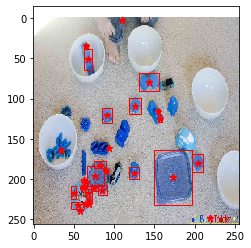

In [21]:
b.showFrames(img_array)
b.clear()

##Now we try to apply K-means clustering algorithm

Our metrics to minimize will be the sum of both color distance and euclidean distance. So we try to catch clusters of colors near to each other.

In [22]:
clusters = KmeansColor(3,img_array,colorBlue,0.0001)

In [45]:
(clusters2,clusteredimage) = KmeansSegmentation(4,img_array,1)

IndexError: list index out of range

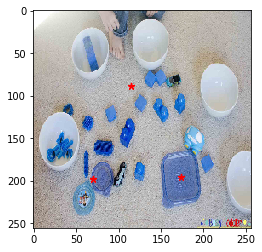

In [24]:
#c = selectBestCluster(clusters)
fig,ax = plt.subplots(1)
for c in clusters:
    ax.imshow(img_array)
    ax.scatter(c.centroid[1],c.centroid[0],marker=(5,2),c = 'r')

In [25]:
#plt.imshow(drawClusters(img_array,clusters2))

9 13
10 13
11 13
11 14
15 27
15 28
15 29
15 30
16 27
16 30
17 27
20 25
21 24
21 25
22 24
22 25
23 17
23 18
24 17
24 18
25 18
35 31
35 32
35 33
35 34
35 35
35 36
35 37
35 40
35 41
36 31
36 32
36 33
36 34
36 35
36 36
36 37
36 40
36 41
37 31
37 32
37 33
37 34
37 35
37 36
37 37
37 40
38 16
38 30
38 31
38 32
38 33
38 34
38 35
38 37
39 15
39 25
39 31
39 32
39 33
39 35
39 36
39 37
40 16
40 31
40 32
40 33
40 35
40 36
40 37
41 31
41 32
41 33
41 34
41 35
41 36
41 37
41 38
42 17
42 31
42 32
42 33
42 34
42 35
42 36
42 37
43 31
43 33
43 34
44 31
44 32
44 34
44 35
44 37
45 31
45 32
9 13
10 13
11 13
11 14
15 27
15 28
15 29
15 30
16 27
16 30
17 27
20 25
21 24
21 25
22 24
22 25
23 17
23 18
24 17
24 18
25 18
35 31
35 32
35 33
35 34
35 35
35 36
35 37
35 40
35 41
36 31
36 32
36 33
36 34
36 35
36 36
36 37
36 40
36 41
37 31
37 32
37 33
37 34
37 35
37 36
37 37
37 40
38 16
38 30
38 31
38 32
38 33
38 34
38 35
38 37
39 15
39 25
39 31
39 32
39 33
39 35
39 36
39 37
40 16
40 31
40 32
40 33
40 35
40 36
40 37
41 31


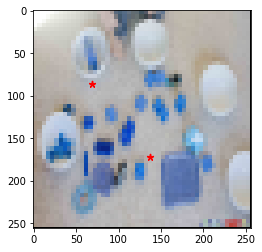

In [31]:
sf = 5
new_image,blue,red = b.imageSectors(img_array,sf)
figure,ax = plt.subplots(1)
ax.imshow(new_image)
meanX = 0
meanY = 0
sumW = 0

for imp in blue:
    x = floor(imp[0] / int(new_image.shape[1]/sf))
    y = (imp[0] - x*int(new_image.shape[1]/sf))
    meanX += imp[1]*(x*sf + sf//2)
    meanY += imp[1]*(y*sf + sf//2)
    sumW += imp[1]
    if imp[1] > 0.75:
        print(x,y)
        rect = ptc.Rectangle((y*sf,x*sf),sf,sf,edgecolor='red', facecolor='none',label='blue')
        #ax.add_patch(rect)
meanX //= sumW
meanY //= sumW
ax.scatter(meanY,meanX,marker=(5,2),c = 'r')

for imp in red:
    x = floor(imp[0] / int(new_image.shape[1]/sf))
    y = (imp[0] - x*int(new_image.shape[1]/sf))
    meanX += imp[1]*(x*sf + sf//2)
    meanY += imp[1]*(y*sf + sf//2)
    sumW += imp[1]
    if imp[1] > 0.75:
        print(x,y)
        rect = ptc.Rectangle((y*sf,x*sf),sf,sf,edgecolor='red', facecolor='none',label='blue')
        #ax.add_patch(rect)
meanX //= sumW
meanY //= sumW
ax.scatter(meanY,meanX,marker=(5,2),c = 'r')




BLOBS ------------------------
15 165 4 9
20 160 4 4
25 190 4 4
30 170 4 4
35 150 9 4
40 120 4 4
40 160 4 4
45 220 4 4
50 210 9 9
50 225 19 14
60 140 4 4
60 165 4 4
60 170 29 49
65 40 9 24
70 155 4 4
70 165 4 4
85 110 14 19
90 165 4 4
90 205 4 4
100 145 4 9
110 125 4 4
110 155 4 4
115 130 4 4
115 145 4 4
120 100 14 19
120 180 4 4
120 190 9 9
130 70 29 19
140 110 4 9
145 120 4 4
150 105 4 9
150 165 59 64
155 115 4 9
165 105 4 9
170 120 4 4
175 100 4 19
175 150 4 4
185 160 4 4
195 250 4 4
205 245 4 4
250 245 4 4
------------------------------


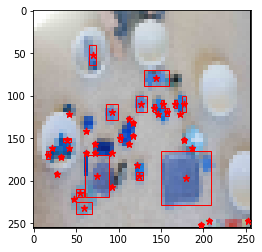

In [32]:
b.search(new_image)
b.showFrames(new_image)
b.clear()

In [33]:
class Box:
    'Box class for the iterative version of the algorithm'
    def __init__(self,identifier):
        self.id = identifier
        self.maxX = -1 #Height of the Box (y)
        self.maxY = -1 #Width of the Box (x)
        self.x = 1000  #x for the start of the box
        self.y = 1000  #y for the start of the box
        self.h = 0
        self.w = 0
        
    def updateBox(self,x,y):
            if x < self.x:
                self.x = x
            if y < self.y:
                self.y = y
            if x > self.maxX:
                self.maxX = x
            if y > self.maxY:
                self.maxY = y    
            self.h = self.maxX - self.x
            self.w = self.maxY - self.y
    
#Iterative Algorithm searching in a BF way
def IterativeBlobDetection(img,cl):
    'iterative Blob detection algorithm'
    numBoxes = 0
    exploredList = set()
    expansionList = []
    boxes = []
    color = cl
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if checkColor(cl,img,i,j) and (i,j) not in exploredList:
                expansionList.append((i,j))
                numBoxes += 1
                boxes.append(Box(numBoxes))
#                 print('Found point '+ str((i,j)))
#                 print('Created the new Box ' + str(boxes[-1].id))
                while(len(expansionList)!= 0):
                    #Then start exploring the nearings using the Expansion List
                    exploredPoint = expansionList[0]
#                     print('exploring point '+ str(exploredPoint))
                    
                    if exploredPoint not in exploredList:
                        exploredList.add(exploredPoint) #put the point in the points already explored
#                         print('added the explored point to the explored List')
                        for di in range(-1,2):
                            if exploredPoint[0]+di < 0 or exploredPoint[0]+di >= img.shape[0]:
                                break
                            for dj in range(-1,2):
                                if exploredPoint[1]+dj < 0 or exploredPoint[1]+dj >= img.shape[1]:
                                    break
                                if checkColor(cl,img,exploredPoint[0]+di,exploredPoint[1]+dj):
                                    expansionList.append((exploredPoint[0]+di,exploredPoint[1]+dj))
#                                     print('added ' + str((exploredPoint[0]+di,exploredPoint[1]+dj))+' to the expansion.')
                                    boxes[-1].updateBox(exploredPoint[0]+di,exploredPoint[1]+dj)
                    expansionList.pop(0)
    return boxes
    

In [34]:
def checkPositionObject(x,y,window,mod,img_height):
    centerX = img_height//2;
    if mod == 0:
        if abs(x-centerX)< window:
            return 2;
        return 0;
    elif mod == 1:
        if x <= centerX - window:
            return -1;
        elif x > (centerX + window):
            return 1;
        return 0;
    return 0;

In [35]:
def show_webcam(mirror=False, modality = 0):
    'function for showing the webcam and having the color recognition'
    cam = cv2.VideoCapture(0)
    cam.set(cv2.CAP_PROP_FPS, 1)
    square = 20
    w = 160
    h = 160
    ratio = w/h
    s = 0
    bgr = [0,0,0]
    rounds1 = 0
    rounds2 = 0
    figure,ax = plt.subplots(1)
    detectedColor = (np.array([0,0,0]),np.array([0,0,0])) #FIRST scan detected color. So the reference one.
    colorB = (np.array([0,0,0]),np.array([0,0,0])) #Dynamically detected color. So the one changing in time.
    colorR = (np.array([0,0,0]),np.array([0,0,0])) #Dynamically detected color. So the one changing in time.
    
    while cv2.waitKey(1) != 13:
        ret_val, imgcam = cam.read()
        imgcam = cv2.resize(imgcam,(w,h))
        if mirror: 
            imgcam = cv2.flip(imgcam, 1)
        for i in range(int(square*ratio)):
            for j in range(square):
                pix = imgcam[i + (imgcam.shape[0]//2) - square//2 ,j + (imgcam.shape[1]//2) - square//2]
                bgr[0]+=pix[0]
                bgr[1]+=pix[1]
                bgr[2]+=pix[2]
                s += 1
        for i in range(3):
            bgr[i] //= s
            detectedColor[0][i] = bgr[i] - 35 if bgr[i] - 35 >= 0 else 0 
            detectedColor[1][i] = bgr[i] + 35 if bgr[i] + 35 <= 255 else 255
        cv2.rectangle(imgcam,(imgcam.shape[0]//2 - int(square*ratio)//2 ,imgcam.shape[1]//2 - square//2 ),( imgcam.shape[0]//2 + int(square*ratio)//2, imgcam.shape[1]//2 + square//2 ),(255,0,0),1)
        cv2.imshow('my webcam', imgcam)
        s = 0
        bgr = [0,0,0]
        colorB = detectedColor
    print("COLOR-------------")            
    print(colorB)    
    print("------------------")
    
    
    
    while cv2.waitKey(1) != 13:
        ret_val, imgcam = cam.read()
        imgcam = cv2.resize(imgcam,(w,h))
        if mirror: 
            imgcam = cv2.flip(imgcam, 1)
        for i in range(int(square*ratio)):
            for j in range(square):
                pix = imgcam[i + (imgcam.shape[0]//2) - square//2 ,j + (imgcam.shape[1]//2) - square//2]
                bgr[0]+=pix[0]
                bgr[1]+=pix[1]
                bgr[2]+=pix[2]
                s += 1
        for i in range(3):
            bgr[i] //= s
            detectedColor[0][i] = bgr[i] - 35 if bgr[i] - 35 >= 0 else 0 
            detectedColor[1][i] = bgr[i] + 35 if bgr[i] + 35 <= 255 else 255
        cv2.rectangle(imgcam,(imgcam.shape[0]//2 - int(square*ratio)//2 ,imgcam.shape[1]//2 - square//2 ),( imgcam.shape[0]//2 + int(square*ratio)//2, imgcam.shape[1]//2 + square//2 ),(255,0,0),1)
        cv2.imshow('my webcam', imgcam)
        s = 0
        bgr = [0,0,0]
        colorR = detectedColor
    print("COLOR-------------")            
    print(colorR)    
    print("------------------")
    
    while True:
        ret_val, imgcam = cam.read()
        imgcam = cv2.resize(imgcam,(w,h))
        if mirror: 
            imgcam = cv2.flip(imgcam, 1)
        if modality == 0:
            newb = BlobsFactory(detectedColor)
            newb.search(imgcam)
            for e in newb.blobs:
                cv2.rectangle(imgcam,(e.x,e.y),(e.x+e.width,e.y+e.height),(0,0,0),1)
                cv2.circle(imgcam,(e.x + e.width//2,e.y + e.height//2),1,(0,0,255),1)
            #newb.clear()
        if modality == 1:
            clus,clusIm = KmeansSegmentation(3,imgcam,1)
#             cbest = selectBestCluster(clus)
#             print(cbest.color)
#             print(len(cbest.points))
#             print(cbest.centroid)
            for cbest in clus:
                if len(cbest.points) > 20:
                    cv2.circle(imgcam,(cbest.centroid[1],cbest.centroid[0]),2,(0,0,0),-1)
            imgcam = clusIm
        if modality == 2:
            sf = 10
            newb = BlobsFactory(colorB,colorR)
            tmp, b, r = newb.imageSectors(imgcam,sf)
            meanX = 0
            meanY = 0
            sumW = 0
            rounds1+=1
            rounds2+=1
            if len(b) != 0:
                for imp in b:
                    x = math.floor(imp[0] / int(new_image.shape[1]/sf))
                    y = (imp[0] - x*int(new_image.shape[1]/sf))
                    meanX += imp[1]*(x*sf + sf//2)
                    meanY += imp[1]*(y*sf + sf//2)
                    sumW += imp[1]
                    if imp[1] > 0.60:
                        cv2.rectangle(imgcam,(y*sf,x*sf),(y*sf + sf,x*sf + sf),(0,0,0),1)
                        cv2.circle(imgcam,(y*sf + sf//2,x*sf + sf//2),1,(0,255,0),1)
                if sumW > 0:
                    meanX //= sumW
                    meanY //= sumW
                    cv2.circle(imgcam,(int(meanY),int(meanX)),2,(255,0,0),2)
            print(checkPositionObject(meanY,meanX,25,0,new_image.shape[1]))
            meanX = 0
            meanY= 0
            sumW = 0
            if len(r) != 0:
                for imp in r:
                    x = math.floor(imp[0] / int(new_image.shape[1]/sf))
                    y = (imp[0] - x*int(new_image.shape[1]/sf))
                    meanX += imp[1]*(x*sf + sf//2)
                    meanY += imp[1]*(y*sf + sf//2)
                    sumW += imp[1]
                    if imp[1] > 0.60:
                        cv2.rectangle(imgcam,(y*sf,x*sf),(y*sf + sf,x*sf + sf),(0,0,0),1)
                        cv2.circle(imgcam,(y*sf + sf//2,x*sf + sf//2),1,(0,255,0),1)
                if sumW > 0:
                    meanX //= sumW
                    meanY //= sumW
                    cv2.circle(imgcam,(int(meanY),int(meanX)),2,(0,0,255),2)
            print(checkPositionObject(meanY,meanX,25,1,new_image.shape[1]))
        if modality == 3:
            boxes = IterativeBlobDetection(imgcam, colorB)
            for e in boxes:
                cv2.rectangle(imgcam,(e.y,e.x),(e.y+e.w,e.x+e.h),(0,0,0),1)
                cv2.circle(imgcam,(e.y + e.w//2,e.x + e.h//2),1,(0,0,255),1)
            
        cv2.imshow('my webcam', imgcam)
        if cv2.waitKey(1) == 27: 
            break  # esc to quit
    cv2.destroyAllWindows()

COLOR-------------
(array([74, 11,  0]), array([144,  81,  52]))
------------------
COLOR-------------
(array([101,  28,   0]), array([171,  98,  58]))
------------------


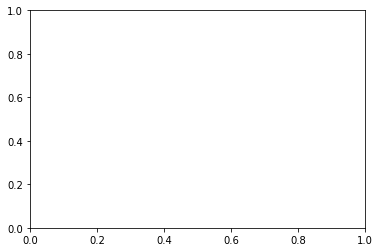

In [36]:
show_webcam(True,3)

In [38]:
boxes_iterative = IterativeBlobDetection(img_array,colorBlue)

39 61 25 12
68 131 23 25
99 119 20 14
112 85 19 13
120 151 12 8
159 84 13 10
164 150 68 47
169 197 23 14
178 47 62 45
185 119 15 12


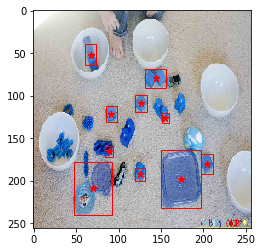

In [39]:
figure,ax = plt.subplots(1)
ax.imshow(img_array)
for box in boxes_iterative:
    if box.w*box.h > 50:
        print(box.x,box.y,box.h,box.w)
        rect = ptc.Rectangle((box.y,box.x),box.w,box.h,edgecolor='red', facecolor='none',label='blue')
        ax.add_patch(rect)
        ax.scatter(box.w/2 + box.y, box.h/2 + box.x ,marker=(5,2),c = 'r')
